# Learn to optimize Mølmer–Sørensen gates for trapped ions
**Creating optimal operations with the trapped ions module**

In this tutorial you will create a gate to efficiently prepare quantum states of trapped ion qubits using Mølmer–Sørensen-type interactions.

This tutorial will introduce you to the [Boulder Opal trapped ions functionality](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/ions) to perform calculations and the [Q-CTRL Visualizer package](https://docs.q-ctrl.com/references/qctrl-visualizer/) to visualize their results.

## Optimizing a Mølmer–Sørensen gate

Your task will be to generate an entangling Mølmer–Sørensen gate for two trapped Ytterbium ions.

Mølmer–Sørensen-type operations entangle multiple ions using laser drives tuned close to the frequency of an ion chain oscillation mode.
Particular drives give rise to [relative phases and phase space displacements](https://doi.org/10.1002/qute.202000044) during an operation.
The [operational infidelity](https://doi.org/10.1002/qute.202000044) of the gate is determined by the relative phases and displacements at the final time of the drives.
In a successful Mølmer–Sørensen operation in an ion chain, the phase-space trajectories for all modes return to zero (that is, avoiding residual internal-motional entanglement), and set the phase acquired between the internal states of each pair of ions to a target value.

The interaction Hamiltonian for Mølmer–Sørensen-type operations in a chain with $N$ ions takes the form ($\hbar=1$ as per Boulder Opal convention)
$$
H(t) = \frac{i}{2} \sum_{j=1}^N
    \sigma_{x, j} \sum_{p=1}^{3N} \eta_{pj} \left( 
        \gamma_j(t) e^{i \delta_p t} a_{p}^\dagger - \gamma_j^\ast(t) e^{-i \delta_p t} a_p
    \right) ,
$$
where the axis dimension and collective mode dimension are combined into a single index $p$ for simplicity,
$\sigma_{x,j}$ is the Pauli $X$ operator for ion $j$,
$\eta_{pj}$ is the Lamb–Dicke parameter of mode $p$ for ion $j$,
$\gamma_j(t)$ is the drive addressing ion $j$,
$a_p$ is the annihilation operator for mode $p$,
and
$\delta_p=\nu_p-\delta$ is the relative detuning of the laser frequency from the motional frequency of mode $p$.

The trapped ions module is capable of finding optimal drives $\gamma_j(t)$ which create the target entangling phases in the system.
With $\psi_{jk}$ indicating the phase between each pair of ions ($j, k$) (indexing from 0), the operation acting on the internal degrees of freedom of the ions can be described as:
$$ U = \exp\left(i \sum_{j=1}^{N-1} \sum_{k=0}^{j-1} \psi_{jk} \sigma_{x,j} \sigma_{x,k} \right) . $$
By [imposing a combination of symmetry to the ions drives](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.024022) and [penalizing the displacement of each mode's center of mass trajectory](https://doi.org/10.1002/qute.202000044), the module can also generate error-robust gates resilient against common noise sources (for example, laser-detuning noise).

Although the trapped ions module can deal with larger ion chains, in this tutorial you will work with a pair of ions and create an entangling gate with a global beam addressing both ions.
With a target phase of $\psi_{10} = \pi/4$, the corresponding entangling operation is then
$$ U = \exp\left(i \frac{\pi}{4} \sigma_{x,0} \sigma_{x,1} \right) =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & \tfrac{1+i}{2} & \tfrac{-1+i}{2} & 0 \\
0 & \tfrac{-1+i}{2} & \tfrac{1+i}{2} & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix} .
$$


### 1. Import libraries

Before doing any calculation with Boulder Opal, you always need to import the necessary libraries.

In this case, import the `numpy`, `matplotlib.pyplot`, `qctrlvisualizer`, and `boulderopal` packages.
To learn more about installing Boulder Opal, see the [Get started](https://docs.q-ctrl.com/boulder-opal/get-started) guide.

In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

### 2. Obtain ion chain properties

Start by specifying the physical parameters for the laser drive and ion trap, and calculating the ion chain properties with the `boulderopal.ions.obtain_ion_chain_properties` function.
The function returns a dictionary containing the Lamb–Dicke parameters and relative detunings.

In [2]:
# Number of ions in the system.
ion_count = 2

# Calculate Lamb–Dicke parameters and relative detunings.
ion_chain_properties = bo.ions.obtain_ion_chain_properties(
    atomic_mass=171,  # Yb ions
    ion_count=ion_count,
    center_of_mass_frequencies=[1.6e6, 1.5e6, 0.3e6],  # Hz
    wavevector=[(2 * np.pi) / 355e-9, (2 * np.pi) / 355e-9, 0.0],  # rad/m
    laser_detuning=1.6e6 + 4.7e3,  # Hz
)
lamb_dicke_parameters = ion_chain_properties["lamb_dicke_parameters"]
relative_detunings = ion_chain_properties["relative_detunings"]

Your task (action_id="1828681") is queued.
Your task (action_id="1828681") has started.
Your task (action_id="1828681") has completed.


### 3. Define optimizable drives

Define the optimizable drives according to the degrees of freedom in the hardware.
In this case, define a single optimizable piecewise-constant complex drive $\gamma(t)$ by creating a `boulderopal.ions.ComplexOptimizableDrive` object.
Pass to it its maximum Rabi rate (modulus) and the ions it addresses in the system (both of them), as well as the number of optimizable piecewise-constant segments it should have.

In [3]:
# Optimizable drive characteristics.
maximum_rabi_rate = 2 * np.pi * 100e3  # rad/s
segment_count = 64

drive = bo.ions.ComplexOptimizableDrive(
    count=segment_count, maximum_rabi_rate=maximum_rabi_rate, addressing=(0, 1)
)

### 4. Define optimization target

Define the duration of the gate to be implemented, as well as the target phases for all the ions.
The target phases must be a strictly lower triangular matrix, that is, $\psi_{kl}$ indicates the total relative phase target for ions $k$ and $l$, with $k > l$.

In [4]:
# Gate duration.
duration = 2e-4  # s

# Target phases.
target_phase = np.pi / 4
target_phases = np.array([[0, 0], [target_phase, 0]])

### 5. Execute optimization

You now have everything necessary to carry out the optimization.
Use the `boulderopal.ions.ms_optimize` function to obtain the optimized pulse that implements the target Mølmer–Sørensen gate.
Pass to it the system parameters, the optimizable drives, as well as the gate duration and the target phases matrix.
You can also use the `cost_history_scope` parameter to request the evolution of the cost value during the optimization.

In [5]:
result = bo.ions.ms_optimize(
    drives=[drive],
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    duration=duration,
    target_phases=target_phases,
    cost_history_scope="ITERATION_VALUES",
)

Your task (action_id="1828688") is queued.
Your task (action_id="1828688") has started.
Your task (action_id="1828688") has completed.


### 6. Extract the optimization outputs

After the calculation is complete, the results are stored in the output of the [returned dictionary](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/ions/ms_optimize), `result`.
It contains the optimized values for each optimizable drive, as well as the optimized system dynamics (the `"phases"`, `"displacements"`, and `"infidelities"`) and the `"sample_times"` at which they're sampled.

#### Extract the final gate infidelity

A low infidelity at the end of the operation ensures us that the ion pairs have acquired the right phases, without generating any entanglement without the internal and external degrees of freedom of the ions.

In [6]:
print(f"Infidelity reached: {result['output']['infidelities']['value'][-1]:.3e}")

Infidelity reached: 6.446e-12


#### Visualize the cost history

You can retrieve the evolution of the cost during the different optimizations from the optimized values dictionary, and plot them with the `plot_cost_histories` function from the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) package.

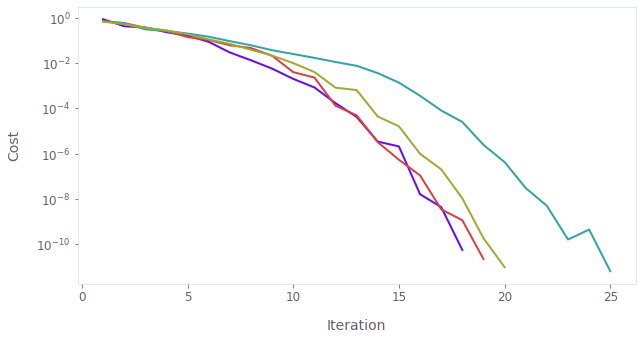

In [7]:
qctrlvisualizer.plot_cost_histories(
    result["cost_history"]["iteration_values"], y_axis_log=True
)

#### Visualize the optimized pulse

You can retrieve the values of the optimized drive from the optimized values dictionary, and plot them with the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/)'s `plot_controls`.

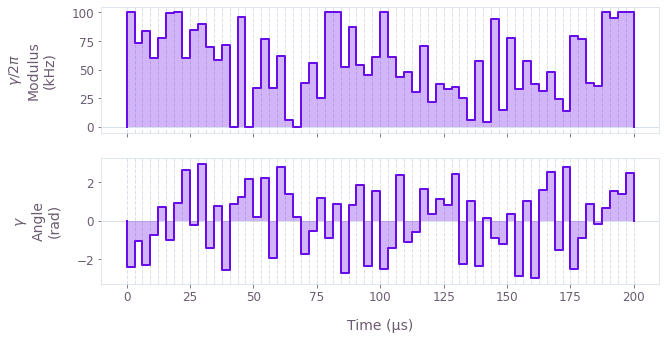

In [8]:
qctrlvisualizer.plot_controls({r"$\gamma$": result["output"]["drive"]})

#### Visualize the phase dynamics

You can easily visualize the dynamics of the relative phase between the two ions over the duration of the gate, by extracting the phases from the result.

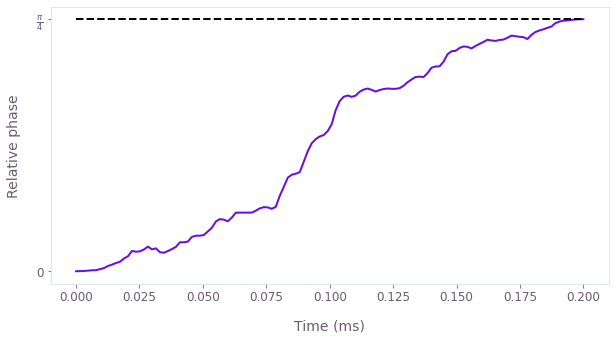

In [9]:
sample_times = result["output"]["sample_times"]["value"] * 1e3
plt.plot(sample_times, result["output"]["phases"]["value"][:, 1, 0])
plt.plot([0, sample_times[-1]], [target_phase, target_phase], "k--")
plt.yticks([0, target_phase], ["0", r"$\frac{\pi}{4}$"])
plt.xlabel("Time (ms)")
plt.ylabel("Relative phase")

plt.show()

For high-fidelity operations, the relative phase obtained at the end of the operation should match the target phase for the ion pair (marked by a horizontal dashed black line).

#### Visualize phase space trajectories


You can visualize the trajectory of the center of a coherent state in (rotating) optical phase space for each mode.
The closure of these trajectories is a necessary condition for an effective operation.
You can obtain the overall displacement for each mode by summing the displacements [over the ion dimension](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/ions/ms_optimize).

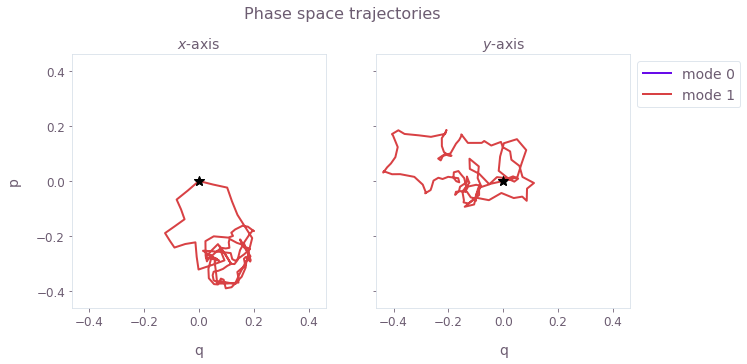

In [10]:
total_displacement = np.sum(result["output"]["displacements"]["value"], axis=-1)

fig, axs = plt.subplots(1, 2)
plot_range = 1.05 * np.max(np.abs(total_displacement))
fig.suptitle("Phase space trajectories")

for k in range(2):
    for mode in range(ion_count):
        axs[k].plot(
            np.real(total_displacement[:, k, mode]),
            np.imag(total_displacement[:, k, mode]),
            label=f"mode {mode % ion_count}",
        )
        axs[k].plot(
            np.real(total_displacement[-1, k, mode]),
            np.imag(total_displacement[-1, k, mode]),
            "k*",
            markersize=10,
        )

    axs[k].set_xlim(-plot_range, plot_range)
    axs[k].set_ylim(-plot_range, plot_range)
    axs[k].set_aspect("equal")
    axs[k].set_xlabel("q")

axs[0].set_title("$x$-axis")
axs[0].set_ylabel("p")
axs[1].set_title("$y$-axis")
axs[1].yaxis.set_ticklabels([])

hs, ls = axs[0].get_legend_handles_labels()
axs[1].legend(handles=hs, labels=ls, loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

Here, $q \equiv q_m = (a_m^\dagger + a_m)/\sqrt{2}$ and $p \equiv p_m = i (a_m^\dagger - a_m)/\sqrt{2}$ are the dimensionless quadratures for each mode $m$.
The black star marks the final displacement for each mode, which overlap at zero; this indicates that the operation has not caused any residual state-motional entanglement or motional heating.
The z-axis modes are not addressed, and thus have no excursions in phase space.

You've reached the end of the tutorial.
Congratulations on obtaining your first Mølmer–Sørensen gate.

You can easily extend the calculations you have done here by having longer ion chains, adding drives that address different ions, trying a robust optimization, etc.
The different classes and functions in the trapped ions module are described in [their reference page](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/ions).

You can perform more flexible optimizations and simulations of Mølmer–Sørensen-type interactions by using [the graph framework in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal).
You can find more information in the [How to optimize error-robust Mølmer–Sørensen gates for trapped ions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-error-robust-molmer-sorensen-gates-for-trapped-ions) and [How to calculate system dynamics for arbitrary Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-system-dynamics-for-arbitrary-molmer-sorensen-gates) user guides

You can also visit our [topics page](https://docs.q-ctrl.com/boulder-opal/topics) to learn more about Boulder Opal and its capabilities.